# Exercise 9: Classification

This homework assignment is designed to give you practice with classification models. We'll try to predict which words are more likely to be responded to correctly during a lexical decision task, based on their length and frequency.

We will be using data from the English Lexicon Project again. However, this time we will use response correctness as our dependent variable. Load **LexicalData_withIncorrect.csv**, which includes incorrect trials as well as correct ones, and also **Items.csv**. Both can be found in the *Homework/lexDat* folder in the class GitHub repository.

This data is a subset of the [English Lexicon Project database](https://elexicon.wustl.edu/). It provides response correctness and reaction times (in milliseconds) of many subjects as they are presented with letter strings and asked to decide, as quickly and as accurately as possible, whether the letter string is a word or not. The **Items.csv** provides characteristics of the words used, namely frequency (how common is this word?) and length (how many letters?).

*Data courtesy of Balota, D.A., Yap, M.J., Cortese, M.J., Hutchison, K.A., Kessler, B., Loftis, B., Neely, J.H., Nelson, D.L., Simpson, G.B., & Treiman, R. (2007). The English Lexicon Project. Behavior Research Methods, 39, 445-459.*

1. Loading and formatting the data 1/1
2. Visualizing the data 1/1
3. Logisic Regression: Fitting the model 2/2
4. Interpreting predictions from the model 3/3
5. QDA 3/3

---
## 1. Loading and formatting the data (1 point)

Load in data from the **LexicalData_withIncorrect.csv** and **Items.csv** files. Use `left_join` to add word characteristics `Length` and `Log_Freq_HAL` from **Items** to the **LexicalData**, and use `drop_na()` to get rid of any observations with missing values. Then use `head()` to look at the first few rows of the data.

*Note: We're just working with `Correct` in this homework, so no need to worry about reformatting reaction times.*

In [ ]:
# WRITE YOUR CODE HERE
# setwd("../Homework datasets/lexDat") # Uncomment this when running for the first time
library(tidyverse)

lex <- read.csv('LexicalData_withIncorrect.csv')
item <- read.csv('Items.csv')

lex |> left_join(item[c('Length', 'Log_Freq_HAL', 'Word')],
	by = join_by(D_Word == Word)) |>
	drop_na() ->
	lex

head(lex)

,X,Sub_ID,Trial,Type,D_RT,D_Word,Outlier,D_Zscore,Correct,Length,Log_Freq_HAL
,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>
1,1,157,1,1,710,browse,false,-0.437,1,6,8.856
2,2,67,1,1,"1,094",refrigerant,false,0.825,1,11,4.644
3,3,120,1,1,587,gaining,false,-0.645,1,7,8.304
4,4,21,1,1,984,cheerless,false,0.025,1,9,2.639
5,5,236,1,1,577,pattered,false,-0.763,1,8,1.386
6,6,236,2,1,715,conjures,false,-0.364,1,8,5.268


---
## 2. Visualizing the data (1 point)

First, we'll try to visualize whether trials that are responded to correctly versus incorrectly differ from each other in terms of word length and log frequency. The code is included below, so that this homework doesn't get too cumbersome. All you have to do is **change the name of the data set**, **run the code**, and **write some observations about the output**.

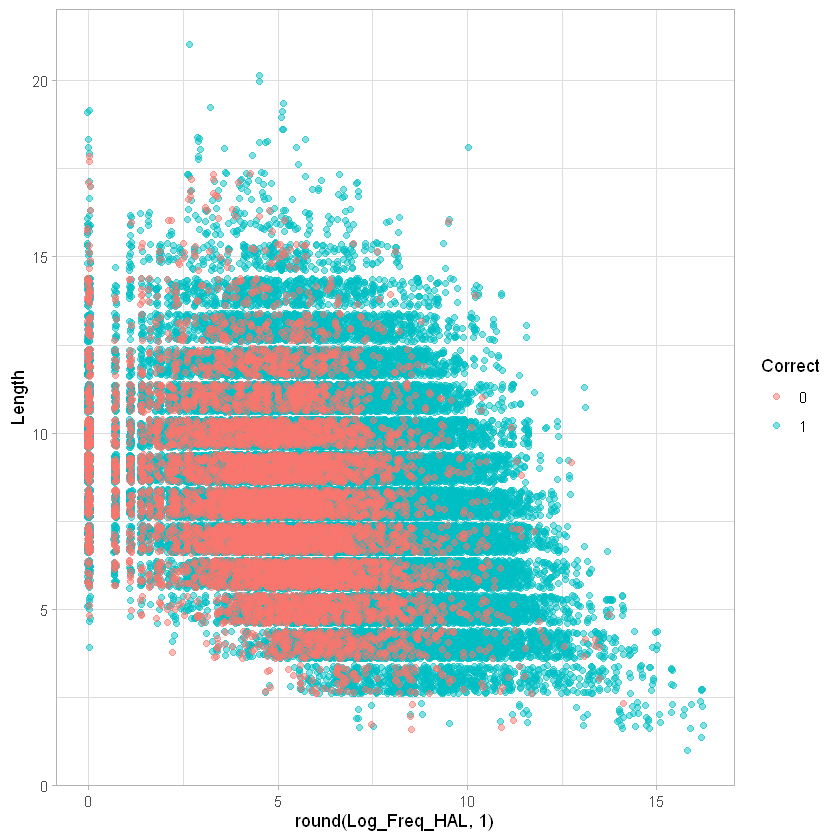

In [ ]:
# require(tidyverse) # Load the tidyverse package, if you haven't yet
lex$Correct <- as.factor(lex$Correct) # so that R knows that Correct is categorical, not numeric.

# plot the Correct / Incorrect clusters
ggplot(lex,aes(x=round(Log_Freq_HAL,1),y=Length,col=Correct)) + geom_point(position="jitter",alpha=0.5) + theme_light()


What do you observe about the "Correct" and "Incorrect" clusters?

> *Write your reponse here*
>
> Short, common words were usually "Correct." It also appears that longer, less common words were less recognized. However, we should also observe that for two equally frequent words, people seem to make fewer mistakes with the longer one.

---
## 3. Logistic Regression: Fitting the model (2 points)

Fit a logistic regression model to the data using `Length`, `Log_Freq_HAL`, and their interaction to predict `Correct`. Use `glm()` to fit the model, and look at its output using `summary()`.

In [ ]:
# WRITE YOUR CODE HERE
glm.fit = glm(Correct ~ Length+Log_Freq_HAL+Length*Log_Freq_HAL,
	data=lex, family=binomial)

summary(glm.fit)



Call:
glm(formula = Correct ~ Length + Log_Freq_HAL + Length * Log_Freq_HAL, 
    family = binomial, data = lex)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.939996   0.115623  -8.130 4.30e-16 ***
Length               0.151266   0.012789  11.828  < 2e-16 ***
Log_Freq_HAL         0.394772   0.018762  21.041  < 2e-16 ***
Length:Log_Freq_HAL -0.010558   0.002202  -4.795 1.63e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 49809  on 70588  degrees of freedom
Residual deviance: 46563  on 70585  degrees of freedom
AIC: 46571

Number of Fisher Scoring iterations: 5


What can you conclude from this output? (a brief gist is fine)

> *Write your response here*
>
> Both the length of the words and their frequency influenced people's responses. The frequency of the word was the stronger factor --- people tended to be correct when the word is frequently used. It's interesting to see that longer words were also more recognizable. The interaction between word length and word frequency existed, but it was not very strong.

---
## 4. Interpreting predictions from the model (3 points)

Finally, look at how well this logistic regression model does at predicting correctness. Use `predict()` and a threshold of 0.5 to generate predicted `Correct` values for each trial, then output a confusion matrix and overall accuracy for these predictions.

*Hint: see the Classifiers tutorial.*

In [ ]:
# WRITE YOUR CODE HERE
glm_prob_df = data.frame(predict(glm.fit, type = "response"))
colnames(glm_prob_df) = c('Predicted_Correct_Prob')


num_observations = nrow(glm_prob_df)
glm_prob_df$index = seq(1, num_observations) #get the observation number for plotting

threshold = 0.50 #binarizing threshold

# First make a list of predicted "Corrects" ()
glm_prob_df$Predicted_Correct=rep(0,num_observations) # initialize to 0

# Then use the probability output to label the up days. Let's use a threshold of 50% probability.
glm_prob_df$Predicted_Correct[glm_prob_df$Predicted_Correct_Prob>threshold]=1 #find the rows that have prob > threshold and cast as 'up'

# Now let's look at the prediction accuracy
confusion_df = data.frame(glm_prob_df$Predicted_Correct, lex$Correct)
colnames(confusion_df) = c('Predicted', 'Actual')

colSums(lex == 0, na.rm = TRUE)
table(confusion_df)


X       Sub_ID        Trial         Type         D_RT       D_Word 
           0            0            0            0            0            0 
     Outlier     D_Zscore      Correct       Length Log_Freq_HAL 
           0          114         7979            0         1244

         Actual
Predicted     0     1
        0    13    44
        1  7966 62566

Did the model do well at predicting lexical decision correctness? Why or why not?

> *Write your response here*  
>
> The overall accuracy is around $\frac{62566+13}{13+44+7966+62566}\approx88.65%$, and it appears that the model did quite well. However, our sample is very imbalanced, with the majority being "Correct" (almost 8:1 ratio). The model only captured 13 out of 7979 incorrect samples. Thus, **we can say the model did well at predicting correctness**, but **did very badly at predicting incorrectness**.

## 5. QDA (3 points)

Load in the `MASS` library and fit a QDA model to the data set. The predictors are still `Length`, `Log_Freq_HAL`, and their interaction, just like the logistic regression model you just ran, and the dependent variable is still `Correct`.

*Hint: see the Classifiers tutorial.*

In [ ]:
# WRITE YOUR CODE HERE
library(MASS)

qda.fit = qda(Correct~Length+Log_Freq_HAL+Length*Log_Freq_HAL, data=lex)
qda.fit

Call:
qda(Correct ~ Length + Log_Freq_HAL + Length * Log_Freq_HAL, 
    data = lex)

Prior probabilities of groups:
        0         1 
0.1130346 0.8869654 

Group means:
    Length Log_Freq_HAL Length:Log_Freq_HAL
0 8.047124     4.932123            37.95260
1 7.979971     6.444849            49.34219

Now look at how well the predicted `Correct` values compare with actual `Correct` values for the whole data set. Output a confusion matrix and overall prediction accuracy.

In [ ]:
# WRITE YOUR CODE HERE
qda.class=predict(qda.fit)$class

qda_confusion_df = data.frame(qda.class, lex$Correct)
table(qda_confusion_df)
colnames(qda_confusion_df) = c('Predicted', 'Actual')
print(paste("Accuracy:",mean(qda.class==lex$Correct)))


         lex.Correct
qda.class     0     1
        0   455  1647
        1  7524 60963

[1] "Accuracy: 0.870078907478502"


How does QDA prediction performance differ from that of logistic regression?

> *Write your response here*
>
> QDA seemed to do better at predicting incorrect samples than logistic regression; however, it did worse at predicting correct samples. Still, QDA missed the majority of incorrect samples.

**DUE:** 5pm EST, March 11, 2024

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here.
> *Someone's Name*